<a href="https://colab.research.google.com/github/mjg-phys/cdm-computing-subgroup/blob/main/FBInferenceTutorial/CDM_computing_inference_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CDM computing workshop: frequentist and Bayesian inference

##Install pymultinest

Press the execute button on the cells below once per runtime

Before we can import pymultinest we need to install Conda, ideally do this on your own machine, but if not, you will need to run this once for each runtime (**not every session**) it takes a little while and will tell you the session crashed

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

!conda install pymultinest

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pymultinest


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.1.0               |       hd590300_1          19 KB  conda-forge
    brotli-bin-1.1.0           |       hd590300_1          19 KB  conda-forge
    ca-certificates-2024.2.2   |       hbcca054_0         152 KB  conda-forge
    cert

##Import packages

In [1]:
#Import required packages
import numpy as np

from scipy.interpolate import interp1d
from scipy.integrate import quad,solve_ivp
from scipy.special import erf, erfc
from scipy.optimize import minimize, root
from scipy.stats import norm, poisson

import matplotlib as mpl
import matplotlib.pyplot as plt

from google.colab import files

import pymultinest

## Dark matter direct detection code

In [2]:
#Code for calucation WIMP scattering rates

#Units
femtometer = 5.06773 #1/GeV
centimeter = 1e13*femtometer
meter = 1e2 * centimeter
kilometer = 1e3 * meter

tonne =  5.6101e29 #GeV

second = 1.51927e24 #1/GeV
year = 365.25 * 24 * 3600 * second

#Define constants
amu  = 0.9315 #GeV         atomic mass unit
mp = 0.9383 #GeV           proton mass
c = 3e8 * meter / second  #speed of light

#DM properties, chosen to match the XENON analysis
rhoX    = 0.3 / centimeter**3
v_0     = 220 * kilometer / second / c
v_earth = v_0 + 12 * kilometer / second / c
v_esc   = 544 * kilometer / second / c

def reducedMass( m1, m2):
    return m1*m2/(m1+m2)

def vMin( Er, mx, mT):
    return np.sqrt( Er * mT / ( 2 * reducedMass( mx, mT)**2 ) )

def Er_max( mx, mT, vmax):
    return 2 * reducedMass( mx, mT)**2 * vmax**2 / mT

def formFactor( q, A):
    qr = q * np.sqrt( (1.23 * A**(1./3) - 0.6)**2 + 2.17706) * femtometer
    s = 0.9 * femtometer

    return 3 * (np.sin(qr) - qr * np.cos(qr)) / qr**3 * np.exp(-(q * s)**2 / 2)

def velDistInt(vmin):

    xesc = v_esc / v_0
    xe   = v_earth / v_0
    xmin = vmin / v_0

    norm = np.pi**(3./2) * v_0**3 * ( erf(xesc) - 4./np.sqrt(np.pi) \
                    * np.exp( - xesc**2) * ( xesc/2 + 1/3 * xesc**3) )

    if vmin < (v_esc - v_earth):
        return np.pi**(3./2) * v_0**2 / ( 2 * norm * xe ) \
          * ( erf( xmin + xe ) - erf( xmin - xe ) - 4*xe / np.sqrt(np.pi)\
              * np.exp( - (xesc**2) ) * ( 1 + xesc**2 - xe**2/3 - xmin**2) )
    elif vmin > (v_esc - v_earth) and vmin < (v_esc + v_earth):
        return np.pi**(3./2) * v_0**2 / ( 2 * norm * xe ) \
         * ( erf( xesc ) + erf( -xmin + xe ) - 2 / np.sqrt(np.pi)\
            * np.exp( -(xesc**2) ) * ( xe + xesc - xmin - 1/3 * (xe - 2*xesc -xmin)\
                                    * (xe + xesc - xmin)**2) )
    else:
        return 0

def DD_diff_rate( Er, mx, sigmaXN, A):

    mT = A * amu

    return rhoX * sigmaXN * A**2/ ( 2 * mx * reducedMass( mx, mp)**2 )  \
    * formFactor( np.sqrt( 2 * mT * Er), A)**2 * velDistInt( vMin( Er, mx, mT))

def DD_numEvents( exposure, A, mx, sigmaXN, Er_min, nPoints):

    #Perform basic trapezoidal integration (sufficient for this example)
    Er_vals = np.linspace( Er_min, Er_max( mx, A*amu, v_esc+v_earth), nPoints)
    dRdEr_vals = list( DD_diff_rate( er, mx, sigmaXN, A) for er in Er_vals)

    return exposure * np.trapz( dRdEr_vals, Er_vals)

#Fit to xenon1t nuclear-recoil efficiency, extra 50% cut for NR ref. region
def XENON1T_eff(Er):
    return .44 * (0.5 * erfc(.3 * (5.4 - Er*1e6)) * 0.5 * erfc(.14 * (Er*1e6 - 42)))

def XENON1T_numEvents( exposure, mx, sigmaXN, nPoints):

    #Perform basic trapezoidal integration (sufficient for this example)
    Er_vals = np.linspace( 1e-6, Er_max( mx, 131*amu, v_esc+v_earth), nPoints)
    dRdEr_vals = list( (XENON1T_eff(er) * DD_diff_rate( er, mx, sigmaXN, 131))\
                      for er in Er_vals)

    return exposure * np.trapz( dRdEr_vals, Er_vals)

# Frequentist example: discovery and setting upper limits

In this example we will calculate direct detection limits for the XENON1T experiment. Note this is a simplified calculation

**Test statistics**

Here we will follow and use of the results of arXiv:1007.1727 ("Asymptotic formulae for likelihood-based tests of new physics", which has become something like a bible for particle physicists).

In this framework the 'new-physics' signal is parameterised by a strength parameter $\mu$, and nuisance parameters by $\theta$.

We will use test statistics based on the log-likelihood ratio. For discovery tests we test the null hypothesis and try to reject it. We will use:

$q_0 = -2\, \rm{log}(\frac{\mathcal{L}(0,\hat{\theta})}{\mathcal{L}(\hat{\mu},\hat{\hat{\theta}})})$      for $\hat{\mu} \geq 0$, $0$ otherwise


For exclusion we test a given signal strength and try to reject it:

$q_\mu = -2\, \rm{log}(\frac{\mathcal{L}(\mu,\hat{\theta})}{\mathcal{L}(\hat{\mu},\hat{\hat{\theta}})})$      for $\mu\geq \hat{\mu}$, $0$ otherwise


**Exercise 1**

Define functions for the likelihoods below, where our full likelihood, $\mathcal{L}(\mu,\hat{\theta})$, will be the product of:

- a poisson term (for number of events observed/expected)
- a normal distribution term (to account for background uncertainty)

Note: ideally you would include the background measurement in the likelihood, but this isn't always practical.

Hint: since we will be working with log likelihoods it is better (numerically) to take the log analytically


In [3]:
#Define the loglikelihood functions

#A poisson likelihood for counting experiments, constants removed
def logPoisson( nExp, nObs):
    return - nExp + nObs * np.log(nExp)

#A normal distribution likelihood for nuisance parameters
# with mean=1 and std. dev. 'relUn', constants removed
def logLikelihoodNuisance( x, npMean, npUn):
    return - (x - npMean)**2 / (2 * npUn**2)

#Likelihood
def logLikelihood_DD( nExp, nObs, npVal, npMean, npUn):
    return logPoisson(nExp, nObs) + logLikelihoodNuisance(npVal, npMean, npUn)

In [5]:
#Define the test statistics q0 and qMu

#Helper function for xenon experiment qMu, -ve because we use minimization below
def _negLike_NPmax( x, muTest, nExpWIMP, nExpBG, bgUn, nObs):
    return -logLikelihood_DD( x[0] + muTest*nExpWIMP, nObs, x[0], nExpBG, bgUn)

#Helper function for xenon experiment qMu
def _negLike_muNPmax( x, nExpWIMP, nExpBG, bgUn, nObs):
    return -logLikelihood_DD( x[0] + x[1]*nExpWIMP, nObs, x[0], nExpBG, bgUn)

#Test statistic for discovery
def q_0( nExpBG, bgUn, nObs):

    nExpWIMP = 1 #just needs to be something non-zero for the fit
    #Find global maximum of likelihood
    resM = minimize( _negLike_muNPmax, [nExpBG, 1], args=(nExpWIMP, nExpBG,\
                                    bgUn, nObs), bounds = ((0, 2*nExpBG), (0,1e5)) )
    maxLogLike = -resM.fun

    #Find conditional maximum likelihood for mu = 0
    resCM = minimize( _negLike_NPmax, [nObs], args=(0, nExpWIMP, \
                                                  nExpBG, bgUn, nObs) )
    condMaxLogLike = -resCM.fun

    if resM.x[1] >= 0:
      return -2 * (condMaxLogLike - maxLogLike)
    else:
      return 0

#Test statistic for upper limits
def q_mu( muTest, nExpWIMP, nExpBG, bgUn, nObs):

    #Find global maximum of likelihood
    resM = minimize( _negLike_muNPmax, [nExpBG, 1], args=(nExpWIMP, nExpBG,\
                                    bgUn, nObs), bounds = ((0, 2*nExpBG), (0,1e5)) )
    maxLogLike = -resM.fun

    #Find conditional maximum likelihood for a given mu = muTest
    resCM = minimize( _negLike_NPmax, [nExpBG], args=(muTest, nExpWIMP, \
                                                  nExpBG, bgUn, nObs) )
    condMaxLogLike = -resCM.fun

    if muTest >= resM.x[1]:
      return -2 * (condMaxLogLike - maxLogLike)
    else:
      return 0

**Note**: for a single bin the maximization of the likelihood ratio can be performed analytically

Now lets build a toy experiment with Monte-Carlo to see these test statistics in action

### Toy Monte-Carlo discovery

Simulate $10^4$ random 'experiments' consistent with a null hypothesis (say, expected background = $100\pm10$), calculating the value of the test statistic $q_0$ for each.

Now do the same with a signal injected, plot the two resulting $q_0$ distributions.

Play around and find how much signal is required to reach a 3$\sigma$ result (i.e. average $q_0$ with signal is greater than 99.9% of $q_0$'s without signal).

Hint: use `np.random.poisson` to produce poission distributed random values


In [12]:
#Toy MC parameters

ToyMC_expBG = 100  #expected number of background events
ToyMC_BGun  = 10   #absolute uncertainty in background rate

ToyMC_H0_NObs_array = np.random.poisson(np.random.normal(ToyMC_expBG,ToyMC_BGun), size=10000)

#now calculate q0
ToyMC_H0_q0_vals = list( q_0( ToyMC_expBG, ToyMC_BGun, nObs) for nObs in ToyMC_H0_NObs_array)

In [7]:
ToyMC_signal = 40  #fake signal to inject

#generate fake data with signal
ToyMC_H1_NObs_array = np.random.poisson(np.random.normal(ToyMC_expBG,ToyMC_BGun)+ToyMC_signal, size=10000)

#now calculate q0 with a fake signal
ToyMC_H1_q0_vals = list( q_0( ToyMC_expBG, ToyMC_BGun, nObs) for nObs in ToyMC_H1_NObs_array)

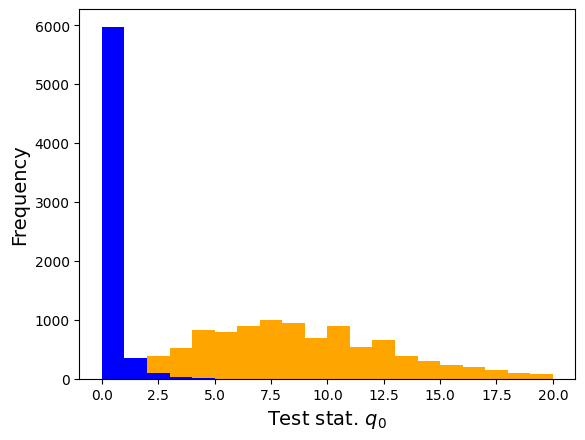

In [8]:
#Plot histograms of the test statistics

range_ = (0, 20)
bins = 20

# Plot the histogram
plt.hist(ToyMC_H1_q0_vals, bins, range_, color='orange', histtype='bar')
plt.hist(ToyMC_H0_q0_vals, bins, range_, color='blue', histtype='bar')

# Add labels and title
plt.xlabel(r"Test stat. $q_0$", fontsize=14)
plt.ylabel(r"Frequency", fontsize=14)

# Display the plot
plt.show()

In [10]:
#median q0 of our signal:
np.median(ToyMC_H1_q0_vals)

8.147445509471481

In [13]:
#what q0 value corresponds to 3sigma (p~=.01)
np.percentile(ToyMC_H0_q0_vals,99.9)

4.10735437842402

**Exercise 3**

Compare the above result with that of the asymptotic formula for the significance $Z = \sqrt(q_0)$ (you'll need to do >10^5 points for a good result)

So for 3$\sigma$ we expect $q_0>9$ only 0.1% of the time

In [ ]:
#SOLUTION



**Exercise 4**

Calculate bounds for XENON1T and compare them to the official results on the plot below.

To do this we will test a WIMP hypothesis $H(m_\chi,\sigma)$ and attempt to reject it in favour of the background only hypothesis, $H_0$.

We will use the results from arXiv:1805.12562 - use the information in Table 1, second column to fill in the values in the function below.

You will also need to find the value of $q_\mu$ that corresponds to the 90%CL (look in  arXiv:1007.1727 or use Monte Carlo, it turns out that the asymptotic formulae are not very accurate for small event numbers but the example here will work fine - see discussion in the paper)



In [14]:
#SOLUTION

q_mu_CL90 =  1.64237

#Helper function for root finding below, returns 0 at correct q_mu
def _q_root( muTest, nExpWIMP, nExpBG, bgUn, nObs):
    return q_mu( muTest, nExpWIMP, nExpBG, bgUn, nObs) - q_mu_CL90

#Return DM-nucleon cross section, sigmaXN (in cm^2) that corresponds to the
# 90%CL in XENON1T, for a given dark matter mass, mx (GeV)
def find_sigmaXN_CL90_XENON1T(mx):

    nExpBG = 7.36
    bgUn = .61
    nObs = 14
    refCS = 1e-44 #scaling the CS helps the root finding

    #Calc number of WIMP events expected from the refCS
    nExpWIMP = XENON1T_numEvents( 1 * tonne * year, mx, refCS * centimeter**2, 200)

    # Find the value of mu for which q_mu = 90%CL
    result = root(_q_root, 10, ( nExpWIMP, nExpBG, bgUn, nObs) )

    return result.x[0]*refCS

In [15]:
#Do the calculation
mass_array = np.logspace( np.log10(4), 3, 20)
sigmaXN_vals = list( find_sigmaXN_CL90_XENON1T( mass) for mass in mass_array)

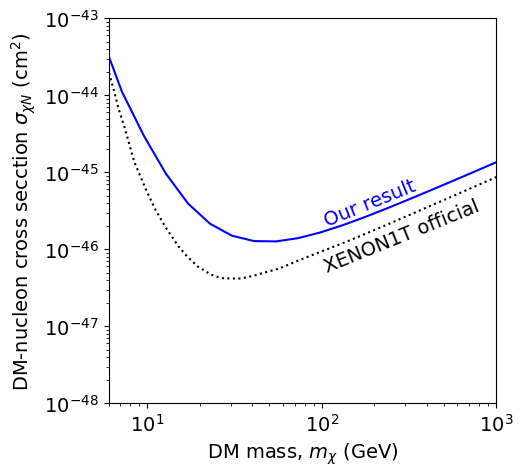

In [16]:
#Define XENON1T limits and make plot
XE1T_official_mDMvals=(5.92677, 6.47151, 6.86234, 7.38349, 8.42415, 9.06302, 9.89391, \
11.1209, 12.6829, 15.1109, 16.7356, 19.3631, 23.0637, 26.4868, \
29.976, 34.6736, 40.1049, 56.8669, 73.8889, 140.143, 229.813, 360.76, \
566.319, 1028.2, 1761.26, 3489.32, 5805.62, 10238.3)
XE1T_official_csVals=1e-44*np.array([2.29082, 1.0968, 0.654963, 0.391138, 0.136103, 0.0918995, 0.0576477, \
0.0327815, 0.0195809, 0.0108668, 0.00829711, 0.00603233, 0.00472159, \
0.00422963, 0.00417985, 0.00418201, 0.00450412, 0.00562534, \
0.00719813, 0.0126923, 0.0202755, 0.0315986, 0.0492453, 0.0889786, \
0.153032, 0.305145, 0.512026, 0.902613])

fig1 = plt.figure(figsize=(5,5))
plt.plot(mass_array, sigmaXN_vals, 'b-',\
         XE1T_official_mDMvals, XE1T_official_csVals, 'k:')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"DM mass, $m_\chi$ (GeV)",fontsize=14)
plt.ylabel(r"DM-nucleon cross secction $\sigma_{\chi N}$ (cm$^2$)",fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(1e-48,1e-43)
plt.xlim(6,1e3)

#Add text to label curve
plt.text(100,5e-47,r"XENON1T official",fontsize=14, rotation=22)
plt.text(100,2e-46,r"Our result",fontsize=14, rotation=22, color='blue')
plt.show()

There are a few reasons why our result doesn't match the official one. The full experimental likelihood includes terms for where the event occurs in the detector and the S1 and S2 values (gives energy and NR/ER discrimination)

#Bayesian example: parameter estimation with MultiNest

In this section we will perform Bayesian inference on a simplified model of dark matter using the MultiNest sampling code

##Define model priors and likelihoods

The dark matter is assumed to be a dirac fermion coupled to quarks via a heavy vector mediator (See appendix B3 of [arXiv:1404.0022](https://arxiv.org/abs/1404.0022)). We will apply constraints to this model from relic density and direct detection.

Our model parameters are:

 `g_DM_V` the coupling constant (universal to all quarks)

 `mDM` the mass of the dark matter

 `mV` the mass of the mediator


In [17]:
#Return sigmav (in 1/GeV**2) for the given model parameters
def simpleModel_sigmav( g_DM_V, mDM, mV, x=20):
    return 6 * g_DM_V**4 * mDM**2 / (np.pi * (mV**2 - 4*mDM**2)**2) \
       * (1 + 9 * (1 + 2 * mDM**2 / mV**2) / (4*x * (1 - 4 * mDM**2 / mV**2)) )

#Return the dark matter-nucleon cross section (1/GeV**2) for the given model parameters
def simpleModel_sigma_DMn( g_DM_V, mDM, mV):
    return 9 * g_DM_V**4 * reducedMass(mDM, mp)**2 / (4 * np.pi * mV**4)


**Relic density likelihood**

This is a quick and dirty approximation of the relic density using our results from Monday (see relic density exercise notebook). Using this will keep the runtime of this example manageable:

In [18]:
massDM_vals = (1.00000000e-01, 1.83298071e-01, 3.35981829e-01, 6.15848211e-01,
       1.12883789e+00, 2.06913808e+00, 3.79269019e+00, 6.95192796e+00,
       1.27427499e+01, 2.33572147e+01, 4.28133240e+01, 7.84759970e+01,
       1.43844989e+02, 2.63665090e+02, 4.83293024e+02, 8.85866790e+02,
       1.62377674e+03, 2.97635144e+03, 5.45559478e+03, 1.00000000e+04)
sigmav_RD_vals = (4.468014306615428e-26,  4.631024682378441e-26,  4.7275523854399196e-26,
 4.6388508744891707e-26,  4.4889735958345066e-26,   4.2823628221229315e-26,
 3.3601828582782445e-26,  2.6813541823865166e-26,  2.4189182713770525e-26,
 2.2793597253871463e-26,  2.193489567265962e-26,  2.155952484983126e-26,
 2.162011250866694e-26,  2.1834613629957402e-26,  2.209373906700691e-26,
 2.2118269354001555e-26,  2.177647511614398e-26,  2.1435046701473533e-26,
 2.14798767140908e-26,  2.091302616498709e-26)

sigmav_theralRelic = interp1d( massDM_vals, sigmav_RD_vals, fill_value=( sigmav_RD_vals[0], sigmav_RD_vals[-1]), bounds_error=False)

#return approximate relic density for a given dark matter mass (GeV) and
# annihilation cross section (1/GeV**2)
def OmegaDMh2_approx( mDM, sigmav):
    return 0.12 * (sigmav_theralRelic(mDM) * centimeter**3/second) / sigmav

#return the likelihood for a given relic density, based on planck data
def planck_OmegaDMh2_loglikelihood(OmegaDMh2):
    return norm.logpdf( OmegaDMh2, loc=0.12, scale=.001)

**Direct detection likelihood**

Here we will approximate the XENON1T likelihood with an error function centred on the official limit (a more complete likelihood could be built from the analysis above, but would be slower)

In [19]:
#Proper DD likelihood -slow- for a given dark matter mass, mDM (GeV) and spin-independent
# cross section, sigma_SI (/GeV**2)
def XENON1T_SI_loglikelihood(mDM, sigma_SI):
    nExpDM = XENON1T_numEvents( 1 * tonne * year, mDM, sigma_SI, 100)
    return poisson.logpmf( 14, 7.36 + nExpDM)

#Interpolate the official xenon1t upper limit
xe1tBound = interp1d( XE1T_official_mDMvals, XE1T_official_csVals*centimeter**2, fill_value=( 1, 1), bounds_error=False)

#Fast DD likelihood for a given dark matter mass, mDM (GeV) and spin-independent
# cross section, sigma_SI (/GeV**2)
def XENON1T_SI_loglikelihood_fast(mDM, sigma_SI):
    return np.log(0.5 * erfc(2 * (sigma_SI / xe1tBound(mDM) - 1) )+1e-100)

In [20]:
parameters=[ "g_DM_A", "mDM", "mV"]
n_pars=len(parameters)

def prior_linear(cube, ndims, npar):

    #set coupling (leave between 0-1)
    cube[0] = cube[0]

    #set DM mass (Unitarity bound at ~100 TeV)
    cube[1] = cube[1]*1e5

    #set mediator mass (start with PeV and see what happens)
    cube[2] = cube[2]*1e7

    return

def loglikelihood(cube, ndims, npar):

    #calculate sigmav -> relic density and loglike
    sigmav = simpleModel_sigmav( cube[0], cube[1], cube[2])
    OmegaDMh2 = OmegaDMh2_approx( cube[1], sigmav)
    relic_den_loglike = planck_OmegaDMh2_loglikelihood(OmegaDMh2)

    #Calculate direct detection cross section -> loglike
    sigmaSI = simpleModel_sigma_DMn( cube[0], cube[1], cube[2])
    DD_loglike = XENON1T_SI_loglikelihood_fast(cube[1], sigmaSI)

    return relic_den_loglike + DD_loglike

##Run MultiNest and analyse results

In [21]:
pymultinest.run( loglikelihood, prior_linear, n_pars,
                 outputfiles_basename="mn_", verbose=False,
                importance_nested_sampling = False, resume = False, n_live_points = 2000,
                evidence_tolerance = 0.0001, sampling_efficiency = 0.1)

a = pymultinest.Analyzer(n_params = n_pars, outputfiles_basename="mn_")
s = a.get_stats()

  analysing data from mn_.txt


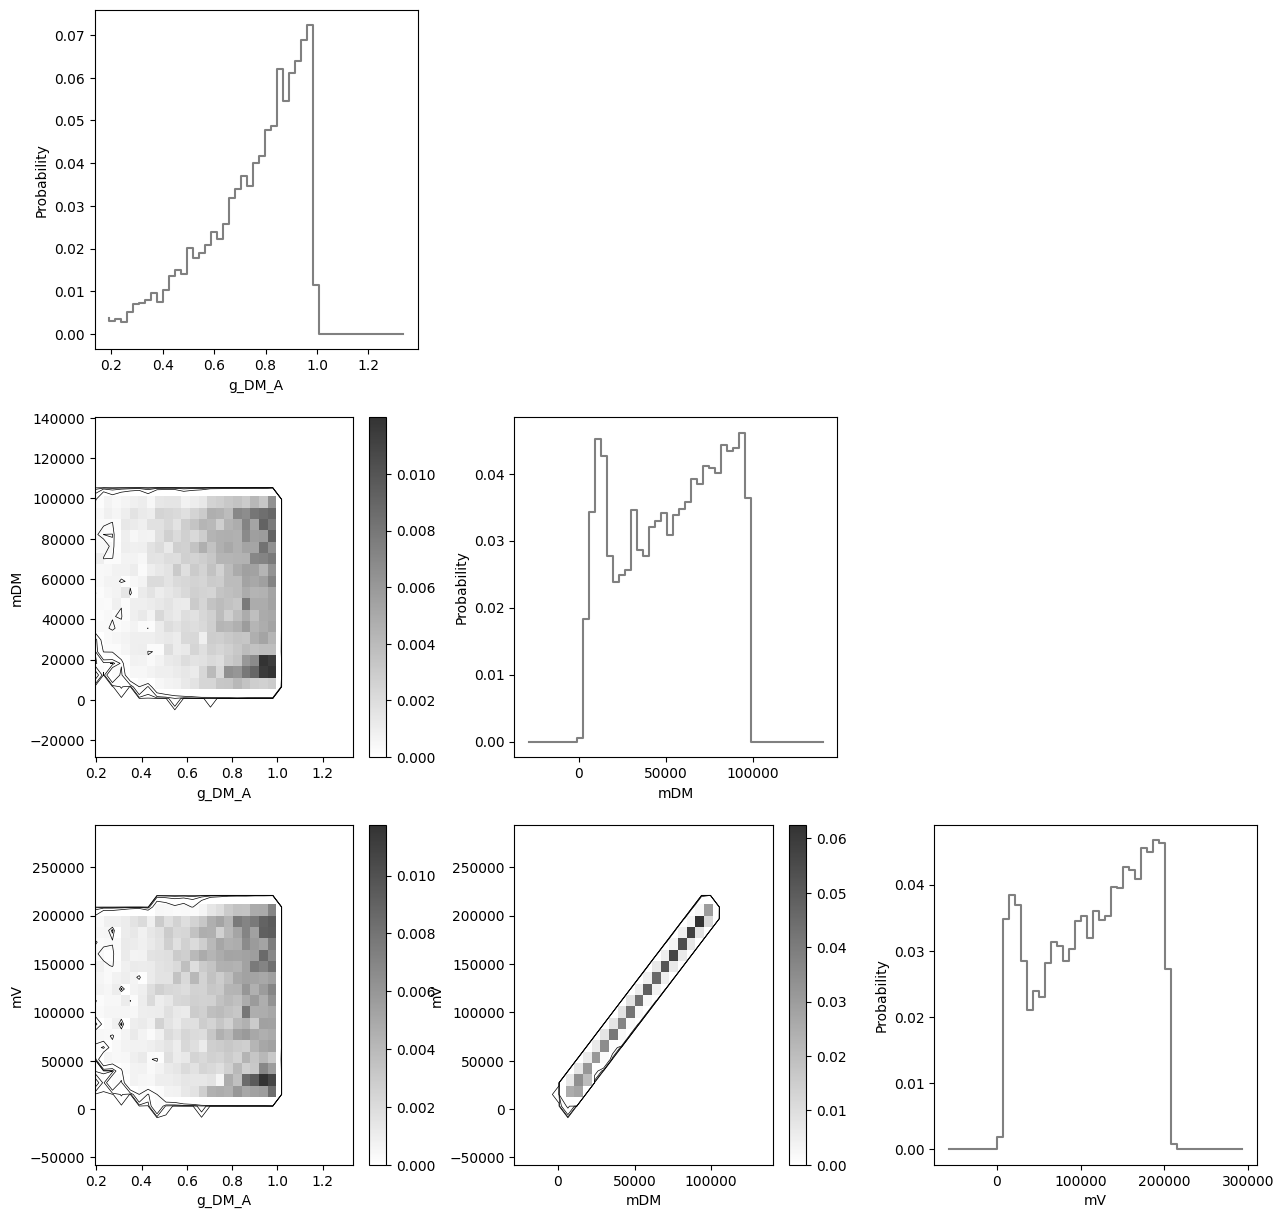

In [22]:
p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_pars, 5*n_pars))

for i in range(n_pars):
    plt.subplot(n_pars, n_pars, n_pars * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])

    for j in range(i):
        plt.subplot(n_pars, n_pars, n_pars * i + j + 1)
        p.plot_marginal(j, i, with_ellipses = False, with_points = False, grid_points=30)
        plt.xlabel(parameters[j])
        plt.ylabel(parameters[i])

plt.subplots_adjust(wspace=.3)

**Exercise 5**

Try the above again, but with log priors

In [ ]:
#SOLUTION

def prior_log(cube, ndims, npar):

    #set coupling (leave between 0-1)
    cube[0] = 10**(cube[0]*-2)

    #set DM mass (Unitarity bound at ~100 TeV)
    cube[1] = 10**(cube[1]*5)

    #set mediator mass (start with ~PeV and see what happens)
    cube[2] = 10**(cube[2]*7)

    return

pymultinest.run( loglikelihood, prior_log, n_pars,
                 outputfiles_basename="mn_logPrior_", verbose=False,
                importance_nested_sampling = False, resume = False, n_live_points = 2000,
                evidence_tolerance = 0.001, sampling_efficiency = 0.1)

a = pymultinest.Analyzer(n_params = n_pars, outputfiles_basename="mn_logPrior_")
s = a.get_stats()


The plot below is horrible because the code cannot plot on a log scale... but it
should illustrate how the posterior is affected by your priors (in this case
skewing the probability to lower values)

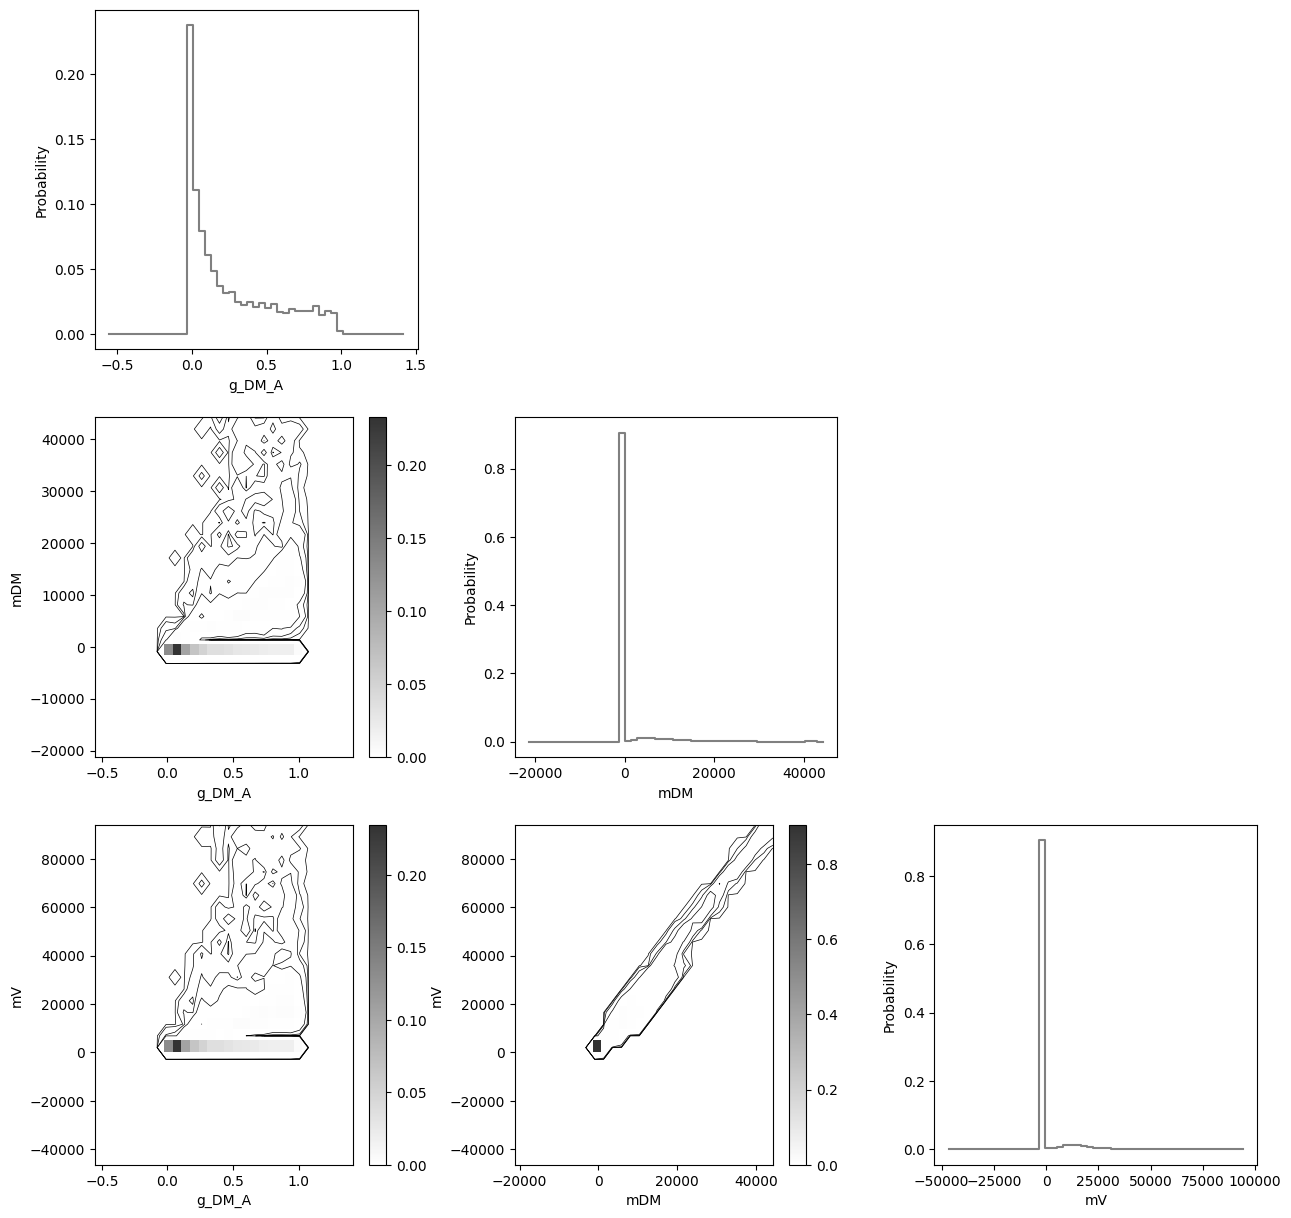

In [ ]:
p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_pars, 5*n_pars))

for i in range(n_pars):
    plt.subplot(n_pars, n_pars, n_pars * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])

    for j in range(i):
        plt.subplot(n_pars, n_pars, n_pars * i + j + 1)
        p.plot_marginal(j, i, with_ellipses = False, with_points = False, grid_points=30)
        plt.xlabel(parameters[j])
        plt.ylabel(parameters[i])

plt.subplots_adjust(wspace=.3)

**Stretch goal exercise**

Use the output from MultiNest to create your own plots (consult the MultiNest documentation *not pymultinest*) in place of the monstrosities above. You could try the superplot package (which I have no experience with).